In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q imantics
!pip install -q segmentation_models_pytorch

In [3]:
import os
import random
import json

from tqdm import tqdm
import imantics
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as A
import sys

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Extract Frames From Video File

In [4]:
input_path = "../input/player-segmentation/"
frame_save_path = "/kaggle/working/frames"

STRIDE = 0.1
MAX_IMAGE_SIZE = 1024

In [5]:
def get_frames_from_video(video_file, stride=1.0):
    """
    video_file - path to file
    stride - i.e 1.0 - extract frame every second, 0.5 - extract every 0.5 seconds
    return: list of images, list of frame times in seconds
    """
    video = cv2.VideoCapture(video_file)
    fps = video.get(cv2.CAP_PROP_FPS)
    i = 0.
    images = []
    frame_times = []

    while video.isOpened():
        ret, frame = video.read()
        if ret:
            images.append(frame)
            frame_times.append(i)
            i += stride
            video.set(1, round(i * fps))
        else:
            video.release()
            break
    return images, frame_times


def resize_if_necessary(image, max_size=1024):
    """
    if any spatial shape of image is greater 
    than max_size, resize image such that max. spatial shape = max_size,
    otherwise return original image
    """
    if max_size is None:
        return image
    height, width = image.shape[:2]
    if max([height, width]) > max_size:
        ratio = float(max_size / max([height, width]))
        image = cv2.resize(image, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_CUBIC)
    return image

In [ ]:
sample_video = '../input/player-segmentation/Test.mp4'

images, frame_times = get_frames_from_video(sample_video, STRIDE)
images = [resize_if_necessary(image, MAX_IMAGE_SIZE) for image in images]

In [ ]:
import math 
plt.figure(figsize=(50,30))
columns = 5
for i, (image, frame_time) in enumerate(zip(images, frame_times)):
    plt.subplot(math.ceil(len(images) / columns + 1), columns, i + 1).set_title("Frame time: " + str(frame_time))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [ ]:
mkdir /kaggle/working/frames

In [ ]:
def process_video(input_path, save_path, stride, max_image_size):

    images, frame_times = get_frames_from_video(input_path, stride)
    images = [resize_if_necessary(image, max_image_size) for image in images]
    for image, frame_time in zip(images, frame_times):
        image_name = str(round(frame_time, 3)).replace(".", "_")
        ssave_path = os.path.join(save_path, "{}.jpg".format(image_name))
        print('saving:  ', ssave_path)
        cv2.imwrite(ssave_path, image)  

process_video(sample_video, frame_save_path, STRIDE, MAX_IMAGE_SIZE)

### Recreate video from frames

In [ ]:
# importing libraries
import os
import cv2 
from PIL import Image 
  
# Video Generating function
def generate_video():
    image_folder = '/kaggle/working/frames' # make sure to use your folder
    video_name = 'mygeneratedvideo.avi'
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider
    # the image files ignoring others if any
    print(images) 
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 10, (width, height)) 
  
    # Appending the images to the video one by one
#     for image in images: 
#         video.write(cv2.imread(os.path.join(image_folder, image))) 
    
    for sec in range(34):
        for frame in range(10):
            img = cv2.imread(f'/kaggle/working/frames/{sec}_{frame}.jpg')
            video.write(img)
      
    # Deallocating memories taken for window creation
#     cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video()

In [6]:
N_IMAGES = 512
TRAIN_IMAGE_SIZE = 512
INPUT_IMAGE_SIZE = (1920, 1080)

In [13]:
with open("../input/player-segmentation/instances_default.json") as f:
    annotations = json.load(f)

map_id_filename = {}
for index in range(len(annotations["images"])):
    map_id_filename[annotations["images"][index]["id"]] = annotations["images"][index]["file_name"]

In [ ]:
#images = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE, 3), dtype=np.uint8)
images = np.zeros((N_IMAGES, 1080, 1920, 3), dtype=np.uint8)

for image_id, image_filename in map_id_filename.items():
    cur_image = cv2.imread(f"../input/player-segmentation/0_500/images/{image_filename}")
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    #cur_image = cv2.resize(cur_image, (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE))

    images[image_id - 1] = cur_image

In [7]:
#masks = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), dtype=bool)
#masks = np.zeros((N_IMAGES, 1080, 1920, 3), dtype=np.uint8)
masks = np.zeros((N_IMAGES, 1024, 1024), dtype=np.uint8)

INPUT_IMAGE_SIZE_ADAPT = (1024, 1024)

for index in range(len(annotations["annotations"])):
    image_id = annotations["annotations"][index]["image_id"]
    segmentation = annotations["annotations"][index]["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*INPUT_IMAGE_SIZE_ADAPT).array
    #cur_mask = cv2.resize(cur_mask.astype(float), (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)) >= 0.5

    masks[image_id - 1] = masks[image_id - 1] | cur_mask

In [7]:
class CFG:
    seed = 42
    train_size = 0.8
    batch_size = 4
    lr = 0.001
    n_epochs = 7
    device = "cuda"
    
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

indexes = list(range(N_IMAGES))
train_indexes = indexes[: int(N_IMAGES * CFG.train_size)]
valid_indexes = indexes[int(N_IMAGES * CFG.train_size) :]

In [8]:
def get_transforms():
    return A.Compose(
        [
            A.HueSaturationValue( # Change colors
                p=1.0, 
                hue_shift_limit=(-20, 20), 
                sat_shift_limit=(-30, 30), 
                val_shift_limit=(-20, 20),
            ),
            A.HorizontalFlip(p=0.5),
        ], 
        p=1.0
    )

In [9]:
class CustomDataset(Dataset):
    def __init__(self, indexes, transform=None, preprocess=None):
        self.indexes = indexes
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        _index = self.indexes[index]

        image = images[_index]
        mask = masks[_index]
        
        if self.transform:
            data = {"image": image, "mask": mask}
            augmented = self.transform(**data)
            image, mask = augmented["image"], augmented["mask"]
        
        if self.preprocess:
            image = self.preprocess(image)
        
        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)

        image = image.permute(2, 0, 1)
        mask = mask.unsqueeze(0)

        return {"image": image, "mask": mask}

### Unet

In [ ]:
# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights="imagenet",
#     in_channels=3,
#     classes=1,
# )

In [ ]:
preprocess_input = get_preprocessing_fn("resnet34", pretrained="imagenet")

In [ ]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)


In [ ]:
# model.to(CFG.device)

# criterion = BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=CFG.lr)

In [ ]:
# def iou(outputs, labels) -> float:
#     intersection = np.sum(np.logical_and(outputs, labels), axis=(1, 2, 3))
#     union = np.sum(np.logical_or(outputs, labels), axis=(1, 2, 3))
#     iou = intersection / union
#     return np.mean(iou)

In [ ]:
# train_loss_history = []
# val_loss_history = []
# train_iou_history = []
# val_iou_history = []

# for epoch in range(CFG.n_epochs):
#     train_loss = 0
#     train_iou = 0
#     model.train()
#     for i, batch in tqdm(enumerate(train_dataloader)):
#         inputs = batch["image"].to(CFG.device)
#         labels = batch["mask"].to(CFG.device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         train_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#         _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
#         train_iou += _iou

#     train_loss /= len(train_dataloader)
#     train_iou /= len(train_dataloader)
#     train_loss_history.append(train_loss)
#     train_iou_history.append(train_iou)

#     val_loss = 0
#     val_iou = 0
#     model.eval()
#     with torch.no_grad():
#         for i, batch in tqdm(enumerate(valid_dataloader)):
#             inputs = batch["image"].to(CFG.device)
#             labels = batch["mask"].to(CFG.device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
#             val_iou += _iou

#     val_loss /= len(valid_dataloader)
#     val_iou /= len(valid_dataloader)
#     val_loss_history.append(val_loss)
#     val_iou_history.append(val_iou)

#     print(
#         "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
#             epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
#         )
#     )

In [ ]:
# plt.figure(figsize=(16, 5))
# plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
# plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

# plt.title("Train and Valid Score", fontsize=16)
# plt.legend(fontsize=15)
# plt.ylabel("iou", fontsize=14)
# plt.xlabel("epoch", fontsize=14)
# plt.grid()
# plt.show()

In [ ]:
# with torch.no_grad():
#     for i, batch in enumerate(valid_dataloader):
#         inputs = batch["image"].to(CFG.device)
#         labels = batch["mask"].to(CFG.device)

#         outputs = model(inputs)

#         np_labels = labels.detach().cpu().numpy()
#         np_outputs = outputs.detach().cpu().numpy()

#         for i in range(len(np_labels)):
#             plt.figure(figsize=(16, 6))
#             plt.subplot(1, 2, 1)
#             plt.imshow(np_labels[i][0])
#             plt.title("Target")
#             plt.subplot(1, 2, 2)
#             plt.imshow(np_outputs[i][0] >= 0)
#             plt.title("Predict")
#             plt.show()
            
#         _iou = iou(np_outputs >= 0, np_labels)
#         val_iou += _iou
#         print(f'iou is {val_iou}')
        
#         break
        
# np_outputs >= 0, np_labels

### train SAM

In [10]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install pycocotools

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3ye3vs5p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3ye3vs5p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=101740 sha256=8e69acf0d28af36ff2c1d167403d2769bf700a3f69b1334ed474fe834a22c22e
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools


In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from collections import defaultdict
from segment_anything.utils.transforms import ResizeLongestSide
#sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth"
#model_type = "vit_h"
model_type = "vit_l"
# 
# vit_b - basically does NOT work, terrible pretrained results
# sam_checkpoint = "/kaggle/input/segment-anything-models/sam_vit_b_01ec64.pth"
# model_type = "vit_b"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
#mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=120,  # Requires open-cv to run post-processing
)

predictor = SamPredictor(sam)

In [13]:
import ipywidgets as widgets


def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))
#---------------------------------------------------       
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='o', s=80, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=80, edgecolor='white', linewidth=1.25)  
#---------------------------------------------------
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=1)
    else:
        color = np.array([200/255, 0/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
#---------------------------------------------------   
def custom_plot(title,image,specific_point):
    input_label = np.array([1])
    #--------------
    masks = mask_generator_2.generate(image)
    
    print('masks')
    #--------------
    predictor.set_image(image)
    masks_p, scores, logits = predictor.predict(
        point_coords=specific_point,
        point_labels=input_label,
        multimask_output=True,
    )
    return masks, masks_p, scores, logits
    #--------------
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
#     #fig.suptitle(f'{title} tumor')
#     plt.axis('off')
#     ax1.imshow(image)
#     ax1.title.set_text("Image")
#     ax2.imshow(image)
#     ax2.title.set_text("Image+Masks")
#     show_anns(masks, ax2)
#     for i, (mask, score) in enumerate(zip(masks_p, scores)):
#         if i==0:
#             ax3.imshow(image)
#             ax3.title.set_text("a specific object")
#             show_points(specific_point, input_label, ax3)
#             show_mask(mask, ax4)
#             ax4.title.set_text(f"Mask - Score: {score:.3f}")
#     for ax in fig.get_axes():
#         ax.label_outer()
#         ax.axis('off')
#-----------------
def draw(img_id):    
    polygon = polygon_map[img_id]
    img = cv2.imread(img_map[img_id])

    blood_vessel = 0
    glomerulus = 0
    unsure = 0
    annotations = []
    for anno in polygon['annotations']:
        if anno['type'] == 'blood_vessel':
            color = (0,255,0)
            blood_vessel += 1
            
        elif anno['type'] == 'glomerulus':
            color = (0,0,0)
            glomerulus += 1
        else:
            color = (255,0,0)
            unsure += 1

        pts = anno['coordinates']
        pts = np.array(pts)
        pts = pts.reshape(-1, 1, 2)
        annotations.append(pts)
        cv2.polylines(img, pts, True, color, 3)
    
    print(f'{blood_vessel = }')
    print(f'{glomerulus = }')
    print(f'{unsure = }')

    plt.imshow(img)
    return annotations

#----------
def draw_sam(img_id, annotations):
    image = cv2.cvtColor(
        cv2.imread('/kaggle/input/hubmap-hacking-the-human-vasculature/train/' + img_id + '.tif'), 
        cv2.COLOR_BGR2RGB
    )
    specific_point = np.array([[50, 100]])
    #custom_plot(img_id, image, specific_point)
    (aa, a, b, c) = custom_plot(img_id, image, specific_point)
    return (aa, a, b, c)
    
output = widgets.Output()

@output.capture()
def ipydisplay(change):
    img_id = change['new']
    ipd.clear_output()
    print("Drawing....")
    annotations = draw(img_id)
    print("Finished Drawing. SAM starting...")
#     print(annotations)
    draw_sam(img_id, annotations)
    plt.axis('off')
    plt.show()
    

# you can only use this widget when actually running the notebook
# select = widgets.Dropdown(options=list(polygon_map.keys()))
# select.observe(ipydisplay, 'value')
# widgets.VBox([select, output])

In [ ]:
def draw_sam(img_id, annotations):
    image = cv2.cvtColor(
        cv2.imread('../input/player-segmentation/0_500/images/' + str(img_id) + '.jpg'), 
        cv2.COLOR_BGR2RGB
    )
    specific_point = np.array([[50, 100]])
    return custom_plot(img_id, image, specific_point)
    
(masks, masks_p, scores, logits) = draw_sam(2, None)
#masks_p, scores, logits

In [ ]:
image = cv2.cvtColor(
        cv2.imread('../input/player-segmentation/0_500/images/2.jpg'), 
        cv2.COLOR_BGR2RGB
    )
image = cv2.resize(image, (256, 256))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
plt.axis('off')
# ax1.imshow(image)
# ax1.title.set_text("Image")
ax2.imshow(image)
ax2.title.set_text("Image+Masks")
show_anns(masks, ax2)
specific_point = np.array([[50, 100]])
# for i, (mask, score) in enumerate(zip(masks_p, scores)):
#     if i==0:
#         ax3.imshow(image)
#         ax3.title.set_text("a specific object")
#         show_points(specific_point, input_label, ax3)
#         show_mask(mask, ax4)
#         ax4.title.set_text(f"Mask - Score: {score:.3f}")
for ax in fig.get_axes():
    ax.label_outer()
    ax.axis('off')

### Train Sam ?

In [86]:
import pycocotools.mask as mask_util
from matplotlib import pyplot as plt

sam_annotations = dict()
for img_id in tqdm(map_id_filename.keys()):
    sam_annotations[img_id] = dict()
    sam_annotations[img_id]['id'] = str(img_id)
    sam_annotations[img_id]['annotations'] = list()
    
    single_mask = None
    for ann in annotations["annotations"]:
        if ann['image_id'] == img_id:
            item = dict()
            item['type'] = 'player'
            item['coordinates'] = list()

            segmentation = ann["segmentation"]
#             polygons = np.array(segmentation)
#             polygon = polygon.reshape((-1, 1, 2)).astype(int)
            rles = mask_util.frPyObjects(segmentation, 1080, 1920)
            rle = mask_util.merge(rles)
            gen_mask = mask_util.decode(rle)
            #gen_mask = cv2.resize(gen_mask, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
            
            if single_mask is None:
                single_mask = gen_mask
            else:
                single_mask += gen_mask

    single_mask = single_mask>0       
    item['coordinates'].append(single_mask)
    sam_annotations[img_id]['annotations'].append(item)

100%|██████████| 512/512 [00:15<00:00, 32.10it/s]


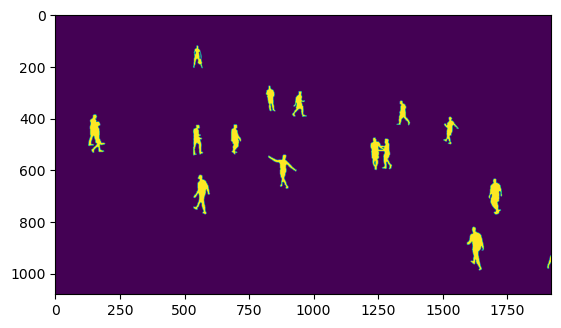

In [89]:
test_mask = sam_annotations[14]['annotations'][0]['coordinates'][0]
plt.imshow(test_mask)
plt.show()
# test_mask.shape
# for i in range(1080):
#     for j in range(1920):
#         if test_mask[i][j] == 1:
#             print('voila')

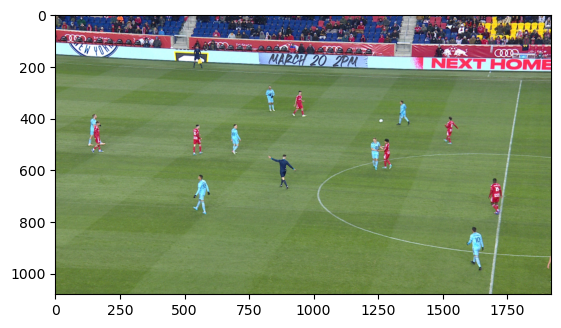

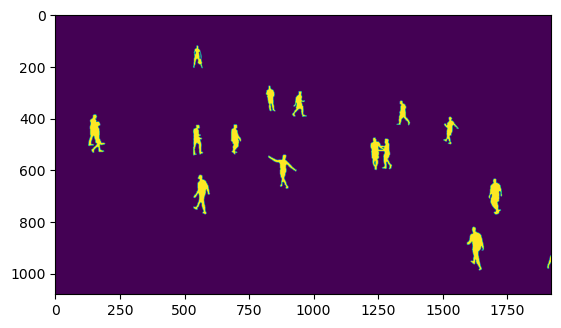

In [71]:
import pycocotools.mask as mask_util
from matplotlib import pyplot as plt

## debug
def generate_coordinates_for_mask(cur_mask):
    mask = np.argwhere(cur_mask.array == True)
    print('mask', mask.shape)
    return mask

def display_image_along_with_segmentation_masks(img_id=111):
    file_name = None
    for im in annotations["images"]:
        if im['id'] == img_id:
            file_name = im['file_name']

    image = cv2.cvtColor(
        cv2.imread(f'../input/player-segmentation/0_500/images/{file_name}'), 
        cv2.COLOR_BGR2RGB
    )
    plt.imshow(image)
    plt.show()

    single_mask = None
    for ann in annotations["annotations"]:
        if ann['image_id'] == img_id:
            polygons = ann['segmentation']
#             polygon = np.array(polygons)
#             polygon = polygon.reshape((-1, 1, 2)).astype(int)
            rles = mask_util.frPyObjects(polygons, 1080, 1920)
            rle = mask_util.merge(rles)
            mask = mask_util.decode(rle)
            if single_mask is None:
                single_mask = mask
            else:
                single_mask += mask
    
    #single_mask = cv2.resize(single_mask, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    single_mask = single_mask>0
    plt.imshow(single_mask)
    plt.show()
    return single_mask
            
single_mask = display_image_along_with_segmentation_masks(img_id = 14)

In [94]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    try:
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
    except:
        print('y_indices', y_indices)
        print('x_indices', x_indices)
        print('ground_truth_map', ground_truth_map)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 1))
    x_max = min(W, x_max + np.random.randint(0, 1))
    y_min = max(0, y_min - np.random.randint(0, 1))
    y_max = min(H, y_max + np.random.randint(0, 1))
    bbox = np.array([x_min, y_min, x_max, y_max])

    return bbox

def get_image_mask_and_bbox(img_ids):
    # For every bounding box(prompt), find the original image and ground truth mask
    bbox_coords = defaultdict(list)
    ground_truth_masks = defaultdict(list)
    transformed_data = defaultdict(dict)
    for img_id in img_ids: 
        image = cv2.imread(f"../input/player-segmentation/0_500/images/{map_id_filename[img_id]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

        transform = ResizeLongestSide(sam.image_encoder.img_size)
        input_image = transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]  

        input_image = sam.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = tuple(transformed_image.shape[-2:])

        transformed_data[img_id]['image'] = input_image[0]
        transformed_data[img_id]['input_size'] = input_size
        transformed_data[img_id]['original_image_size'] = original_image_size
        
        for annotation in sam_annotations[img_id]["annotations"]:
            #print('sam_annotations[img_id]["annotations"]', annotation)
#             ground_truth_mask = convert_polygon_to_binary(annotation['coordinates'])
#             print("ground_truth_mask: ", ground_truth_mask)

            ground_truth_masks[img_id].append(annotation['coordinates'][0])
            bbox_coords[img_id].append(get_bounding_box(annotation['coordinates'][0]))

    return transformed_data, ground_truth_masks, bbox_coords

In [92]:
def convert_polygon_to_binary(polygon):
    polygon = np.array(polygon)
    
    #polygon = polygon.reshape((-1, 1, 2))

    rles = mask_util.frPyObjects(polygon, 1080, 1920)
    rle = mask_util.merge(rles)
    gen_mask = mask_util.decode(rle)
    gen_mask = cv2.resize(gen_mask, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
            
    # Create an empty mask
    mask = np.zeros((512, 512), dtype=np.uint8)
    # Fill the polygon area in the mask
    cv2.fillPoly(mask, [polygon], color=1)
    return mask

In [95]:
device = "cuda"
from collections import defaultdict
from segment_anything.utils.transforms import ResizeLongestSide

class PSDataset(torch.utils.data.Dataset):
    def __init__(self, img_ids, device):
        self.img_ids = img_ids
        self.device = device
        results = get_image_mask_and_bbox(img_ids)
        self.transformed_data, self.ground_truth_masks, self.bbox_coords = results 
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        return self.transformed_data[img_id], self.ground_truth_masks[img_id], self.bbox_coords[img_id]

train_len, test_len = 480, 40
train_dataset = PSDataset(list(sam_annotations.keys())[:train_len], device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True) 
test_dataset = PSDataset(list(sam_annotations.keys())[train_len:train_len+test_len], device)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True) 

In [97]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
#wandb_api = user_secrets.get_secret("api_wandb")

epochs = 10
wandb.login(key='3d1ea92c9996d6ca0b364af566e085cb8dccae9d')
wandb.init(
    # set the wandb project where this run will be logged
    project="Capillaries",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "SAM-finetune mask decoder",
    "dataset": "Only 20 images",
    "epochs": epochs,
    }
)
wandb_logger = WandbLogger()

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [98]:
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# from collections import defaultdict
# from segment_anything.utils.transforms import ResizeLongestSide
# sam_checkpoint = "/kaggle/input/segment-anything-models/sam_vit_h_4b8939.pth"
# model_type = "vit_h"
# device = "cuda"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# Set up the optimizer, hyperparameter tuning will improve performance here
# lr = 1e-3
# wd = 0
# optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# loss_fn = torch.nn.MSELoss()

# Consider changing the loss function to Dice Loss or BCE Loss
# class DiceLoss(torch.nn.Module):
#     def __init__(self, eps=1e-5):
#         super().__init__()
#         self.eps = eps
        
#     def forward(self, output, target):
#         intersection = (output * target).sum()
#         union = output.sum() + target.sum() + self.eps
#         dice_score = 2.0 * intersection / union
#         return -(1.0 - dice_score)

# loss_fn = DiceLoss()
loss_fn = torch.nn.BCELoss()

In [99]:
import pytorch_lightning as pl
from torch.nn.functional import threshold, normalize
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchvision.utils import make_grid

class MyModel(pl.LightningModule):
    def __init__(self, sam, loss_fn, plot_every_x_steps):
        super(MyModel, self).__init__()
        self.sam = sam
        self.loss_fn = loss_fn
        self.plot_every_x_steps = plot_every_x_steps
        self.transform = ResizeLongestSide(sam.image_encoder.img_size)
    
    def forward_pass(self, transformed_data, ground_truth_masks, bbox_coords):
        input_image = transformed_data['image'].to(self.device)
        input_size = transformed_data["input_size"]
        original_image_size = transformed_data["original_image_size"]
        input_size = (input_size[0].item(), input_size[1].item())
        original_image_size = (original_image_size[0].item(), original_image_size[1].item())
        losses = []

        for i in range(len(ground_truth_masks)):
            ground_truth_masks[i] = ground_truth_masks[i][0].to(self.device)
            prompt_box = bbox_coords[i][0].cpu().numpy()
            
            with torch.no_grad():
                image_embedding = self.sam.image_encoder(input_image)
                box = self.transform.apply_boxes(prompt_box, original_image_size)
                box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)
                box_torch = box_torch[None, :]

                sparse_embeddings, dense_embeddings = self.sam.prompt_encoder(
                    points=None,
                    boxes=box_torch,
                    masks=None,
                )

            low_res_masks, _ = self.sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=self.sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            upscaled_masks = self.sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(self.device)
            probability_mask = torch.sigmoid(upscaled_masks[0,0])
            
            print('input_image shape', input_image.shape)
            print('probability_mask shape', probability_mask.shape)
            
            loss = self.loss_fn(probability_mask, ground_truth_masks[i].float())
            losses.append(loss)
            last_upscaled_mask = upscaled_masks

        mean_loss = torch.stack(losses).mean()

        return mean_loss, last_upscaled_mask

    def training_step(self, batch, batch_idx):
        transformed_data, ground_truth_masks, bbox_coords = batch
        if len(ground_truth_masks) == 0:
            return None
        self.last_imgs = transformed_data['image'] 
        self.last_masks = ground_truth_masks[-1]
        mean_loss, last_upscaled_mask = self.forward_pass(transformed_data, ground_truth_masks, bbox_coords)
        self.last_upscaled_masks = last_upscaled_mask
        #self.log('train_loss', mean_loss)
        self.log("train_loss", mean_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_images()
        return mean_loss

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        transformed_data, ground_truth_masks, bbox_coords = batch
        if len(ground_truth_masks) == 0:
            return None
        self.last_imgs = transformed_data['image'] 
        self.last_masks = ground_truth_masks[-1]
        mean_loss, last_upscaled_mask = self.forward_pass(transformed_data, ground_truth_masks, bbox_coords)
        self.last_upscaled_masks = last_upscaled_mask
        self.log('val_loss', mean_loss)
        self.log_images()
        return mean_loss   
    
    def configure_optimizers(self):
        lr = 1e-3
        wd = 0
        optimizer = torch.optim.Adam(self.sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
     
    def log_images(self):
        if True or self.global_step % self.plot_every_x_steps == 0:  # plot every x epochs
            last_img = self.last_imgs[0].cpu().numpy().transpose(1,2,0)
            last_mask = self.last_masks[0].detach().cpu().numpy()
            last_upscaled_mask = self.last_upscaled_masks[0,0].detach().cpu().numpy()
#             fig, ax = plt.subplots(3, 1, figsize=(15, 15))

#             ax[0].imshow(last_img)
#             ax[0].title.set_text('Input Images')

#             ax[1].imshow(last_mask, cmap='gray')
#             ax[1].title.set_text('Ground Truth Masks')

#             ax[2].imshow(last_upscaled_mask, cmap='gray')
#             ax[2].title.set_text('Upscaled Masks')

#             plt.show()
            self.logger.experiment.log({
                "Input Images": wandb.Image(last_img),
                "Ground Truth Masks": wandb.Image(last_mask, mode='L'),
                "Predicted (upscaled) Masks": wandb.Image(last_upscaled_mask, mode='L'),
            })
        

model = MyModel(sam, loss_fn, plot_every_x_steps=10)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",  # assumes you have a validation step where you log a "val_loss"
    mode="min",
    every_n_epochs=5,  # change this to save every X epochs
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # assumes you have a validation step where you log a "val_loss"
    patience=3,
    mode='min'
)
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=10,
)
trainer.fit(model, train_loader, val_loader)
wandb.finish()

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])


Training: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

Validation: 0it [00:00, ?it/s]

input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([1, 3, 1024, 1024])
probability_mask shape torch.Size([1080, 1920])
input_image shape torch.Size([

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▁▁▁▁▁▁▁▁
train_loss_step,▄▅▃▂▄▄▂▃▂▂▃▃▃█▃▂▂▂▃▃▃▂▂▂▂▂▃▂▂▁▁▃▃▂▂▂▃▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▅▇▁▂▂▁
epoch,8
train_loss_epoch,0.00556
train_loss_step,0.00615
trainer/global_step,4319
val_loss,0.0057
